In [1]:
import re
import nltk
from nltk.corpus import reuters, stopwords
import numpy as np
import pandas as pd
import random
nltk.download('reuters')
nltk.download('stopwords')


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/ujjwaljain/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ujjwaljain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Co-Occurence Matrix Implementation

In [2]:
tokens = []
dict_words = {}
counter = 0
token = ""

In [3]:
stop_words = set(stopwords.words('english'))
vocab = set()
counter = 0
token = ""
raw_data = reuters.raw().lower()
raw_data = raw_data[0:500000]
for char in raw_data:
    if(char == ' ' and len(token) > 0):
        if token in stop_words:
            token = ""
            continue
        else:
            tokens.append(token)
            if token not in dict_words.keys():
                dict_words[token] = counter
                counter += 1
            token = ""
    elif(char >= 'a' and char <= 'z'):
        token = token + char
vocab.update(tokens)
vocab_size = len(vocab)


In [4]:
key_list = list(dict_words.keys())
coMatrix = np.zeros((len(dict_words), len(dict_words)), dtype = int)

# Window Size for Coocurrence Matrix
k = 5 

In [5]:
for idx, token in enumerate(tokens):
    start = 0 if 0 > idx - k else idx - k
    end = len(tokens) if len(tokens) < idx + k else idx + k
    context_words = tokens[start:idx] + tokens[idx+1:end]
    for context_word in context_words:
        coMatrix[dict_words.get(token)][dict_words.get(context_word)] += 1
    

In [6]:
coMatrix_df = pd.DataFrame(coMatrix, columns = dict_words.keys(), index = dict_words.keys())

In [7]:
coMatrix_df

,asian,exporters,fear,damage,usjapan,rift,mounting,trade,friction,us,...,disney,holly,lthly,roy,shamrock,sugars,contingent,inspections,aspects,jordan
asian,0,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
exporters,1,0,1,1,1,1,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
fear,1,1,0,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
damage,1,1,2,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
usjapan,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sugars,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
contingent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
inspections,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aspects,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def cosineSimilarityValue(word1, word2):
    Embedding_1 = coMatrix_df[word1]
    Embedding_2 = coMatrix_df[word2]
    dot_prdt = np.dot(Embedding_1, Embedding_2)
    squareSum_1 = 0
    squareSum_2 = 0
    for i in range(len(Embedding_1)):
        squareSum_1 += Embedding_1[i] * Embedding_1[i]
        squareSum_2 += Embedding_2[i] * Embedding_2[i]
    mod_1 = np.sqrt(squareSum_1)
    mod_2 = np.sqrt(squareSum_2)
    if(mod_1 == 0 or mod_2 == 0):
        return 0
    cosine_similarity = (dot_prdt) / ((mod_1) * (mod_2))
    return cosine_similarity

In [9]:
def coWords(word):
    coList = coMatrix_df.loc[word].sort_values(ascending=False).head(10)
    print(coList)

In [10]:
def similarWords(word):
    cosineSimDict = {}
    for i in dict_words.keys():
        cosineSimDict[i] = cosineSimilarityValue(word, i)
    cosineSimDict = sorted(cosineSimDict.items(), key=lambda x:x[1], reverse = True)
    df = pd.DataFrame.from_dict(cosineSimDict)
    return df

In [11]:
# print(similarWords('japan').head(10))

In [12]:
# Other method of computing SVD without using library is taking too long of a time even for less number of words

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(coMatrix)
X_svd

array([[ 8.82389121e-02,  1.66299820e-02],
       [ 2.59845368e+00, -5.50150030e-02],
       [ 2.95780418e-01, -1.92542127e-02],
       ...,
       [ 3.53269442e-02, -2.35914804e-03],
       [ 8.81872754e-02, -5.33050267e-03],
       [ 1.14814821e-01, -5.14993612e-03]])

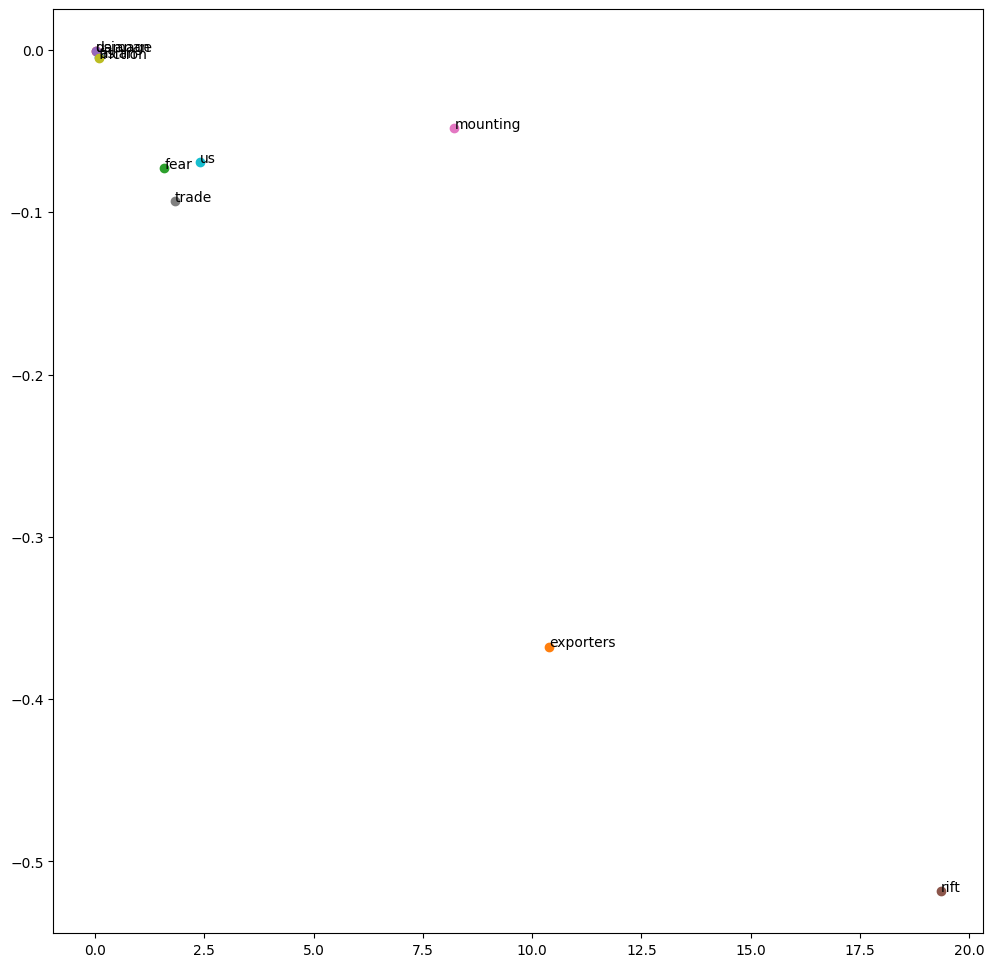

In [13]:
import matplotlib.pyplot as plt

# Generate 50 random points in a 2D array
points = X_svd[150:160]

# Plot the points with labels
fig, ax = plt.subplots(figsize=(12,12))
for i, (x, y) in enumerate(points):
    ax.scatter(x, y)
    ax.annotate(key_list[i], (x, y))

plt.show()

# Word2Vec Implementation

In [14]:
# Set hyperparameters
embedding_dim = 50
window_size = 5
epochs = 10
learning_rate = 0.1


In [15]:
def isTest(fileid):
    return fileid[:4] == 'test'


In [16]:
word_index = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_index.items()}


In [17]:
print("Vocabulary: ", list(vocab))
print('Number of unique words:', vocab_size)
print('word_to_index : ', word_index)
print('index_to_word : ', idx_to_word)


Vocabulary:  ['reporting', 'silver', 'fema', 'packed', 'economic', 'soviets', 'fences', 'prepare', 'win', 'compliance', 'generale', 'division', 'masbate', 'decided', 'tests', 'steels', 'mark', 'leave', 'ahvaz', 'ltisumt', 'rupees', 'digest', 'valu', 'comserv', 'staff', 'curious', 'marcus', 'enormous', 'presidential', 'septaug', 'block', 'downwards', 'cartel', 'halts', 'subject', 'satisfied', 'sprinkel', 'overstressed', 'obtain', 'perserve', 'suitable', 'haute', 'opening', 'personal', 'pattern', 'authority', 'careful', 'heads', 'paranavai', 'professional', 'scheduled', 'rate', 'lost', 'unadjusted', 'sought', 'protected', 'negotiators', 'owns', 'cope', 'lead', 'miguel', 'evident', 'maturity', 'pressthey', 'activity', 'mexican', 'endaprilearlymay', 'laboratories', 'patient', 'interbank', 'manpower', 'takeorpay', 'betz', 'delaying', 'foodgrain', 'imf', 'minus', 'view', 'ltcascade', 'south', 'sense', 'manufacturers', 'oilreliant', 'flavoring', 'gelco', 'neighbourhood', 'getting', 'annual', 

In [18]:
def get_one_hot_vectors(target_word, context_words, vocab_size, word_index):

    # Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)

    index_of_word_dictionary = word_index.get(target_word)
    # Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1

    # Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)

    for word in context_words:
        if(word in vocab):
            index_of_word_dictionary = word_index.get(word)
            ctxt_word_vector[index_of_word_dictionary] = 1

    return trgt_word_vector, ctxt_word_vector


In [19]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


In [20]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


In [21]:
W = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
C = np.random.uniform(-1, 1, (vocab_size, embedding_dim))


In [22]:
def generate_training_data(tokens, window_size, vocab_size, word_index):

    training_data = []
    training_sample_words = []
    for i, word in enumerate(tokens):

        target_word = word
        context_words = []

        if target_word in vocab:
            ncw = set()
            context_words = tokens[max(
                0, i - window_size):i] + tokens[i + 1:min(len(tokens), i + window_size + 1)]
            ncw.update(target_word)
            ncw.update(context_words)
            non_context_words = random.sample(list(vocab), 5)
            trgt_word_vector, ctxt_word_vector = get_one_hot_vectors(
                target_word, context_words, vocab_size, word_index)
            trgt_word_vector, nctxt_word_vector = get_one_hot_vectors(
                target_word, non_context_words, vocab_size, word_index)
            training_data.append(
                [trgt_word_vector, ctxt_word_vector, nctxt_word_vector])
            training_sample_words.append(
                [target_word, context_words, non_context_words])

    # training_data = np.array(training_data)
    return training_data, training_sample_words


In [23]:
training_data, training_sample_words = generate_training_data(
    tokens, window_size, vocab_size, word_index)
print("Training Data: ", len(training_data))
for i in range(len(training_data[:5])):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %
          (training_sample_words[i][0], training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %
          (training_sample_words[i][1], training_data[i][1]))
    print('Non Context word:%s . Non Context  vector: %s ' %
          (training_sample_words[i][2], training_data[i][2]))


Training Data:  46926
**************************************************
Target word:asian . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['exporters', 'fear', 'damage', 'usjapan', 'rift'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
Non Context word:['peripheral', 'slightly', 'metal', 'londrina', 'arising'] . Non Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target word:exporters . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['asian', 'fear', 'damage', 'usjapan', 'rift', 'mounting'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
Non Context word:['steering', 'exporting', 'heyman', 'scapegoat', 'pooled'] . Non Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target word:fear . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['asian', 'exporters', 'damage', 'usjapan', 'rift', 'mounting', 'trade'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
Non Context word:['portugal', 'hostages'

In [24]:
def training(target_word, context_words, non_context_words, w, c):
    loss = 0
    derloss = 0
    ind = np.where(target_word == 1)[0][0]
    for index in np.where(context_words == 1)[0]:
        loss += np.log(sigmoid(np.dot(w[ind].T, c[index])))
        term = (sigmoid(np.dot(w[ind].T, c[index])) - 1)
        derloss += (term)*c[index]
        c[index] = c[index] - (learning_rate*((term)*(w[ind])))
    for index in np.where(non_context_words == 1)[0]:
        loss += np.log(sigmoid(np.dot(w[ind].T, (c[index]*(-1)))))
        term = sigmoid(np.dot(w[ind].T, c[index]))
        derloss += (term)*c[index]
        c[index] = c[index] - (learning_rate*((term)*(w[ind])))

    w[ind] = w[ind] - (learning_rate*derloss)
    return w, c, -loss


In [25]:
for epoch in range(epochs):
    tot_loss = 0

    for target, context, non_context in training_data:
        W, C, loss = training(target, context, non_context, W, C)
        tot_loss += loss
    print('Epoch: %s. Loss:%s' % (epoch, tot_loss))


Epoch: 0. Loss:467610.5981562769
Epoch: 1. Loss:242001.52629957462
Epoch: 2. Loss:185348.2886135744
Epoch: 3. Loss:149333.82100689982
Epoch: 4. Loss:123376.02522584316
Epoch: 5. Loss:104752.06685967722
Epoch: 6. Loss:91875.59881321074
Epoch: 7. Loss:83158.00532241676
Epoch: 8. Loss:77235.56482534843
Epoch: 9. Loss:73137.14945910177


In [26]:
# Resulting Word Embeddings
result = np.add(W, C)
len(result)


7024

In [27]:
# Input vector, returns nearest word(s)
def cosine_similarity(word, weight, word_to_index, vocab_size, index_to_word, no_of_words=vocab_size):

    # Get the index of the word from the dictionary
    index = word_to_index[word]

    # Get the correspondin weights for the word
    word_vector_1 = weight[index]

    word_similarity = {}

    for i in range(vocab_size):

        word_vector_2 = weight[i]

        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * \
            np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den

        word = index_to_word[i]
        word_similarity[word] = theta

    word_similarity = dict(sorted(word_similarity.items(
    ), key=lambda x: x[1], reverse=True)[1:no_of_words+1])

    return word_similarity  # words_sorted


In [28]:
def wordreturn(tr1, tr2, tr3, emb):  # Get word for relationships
    trwt1 = emb[word_index[tr1]]
    trwt2 = emb[word_index[tr2]]
    trwt3 = emb[word_index[tr3]]
    res = trwt3 - trwt1 + trwt2
    word_similarity = {}

    for i in range(vocab_size):

        word_vector_2 = emb[i]

        theta_sum = abs(np.dot(res, word_vector_2))
        theta_den = np.linalg.norm(res) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den

        word = idx_to_word[i]
        word_similarity[word] = theta

    words_sorted = dict(sorted(word_similarity.items(),
                        key=lambda x: x[1], reverse=True))

    return words_sorted


In [29]:
def print_similar_words(top_n_words, weight, words_subset):

    columns = []

    for i in range(0, len(words_subset)):
        columns.append('similar:' + str(i+1))

    df = pd.DataFrame(columns=columns, index=words_subset)
    df.head()

    row = 0
    for word in words_subset:

        # Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(
            word, weight, word_index, vocab_size, idx_to_word)
        col = 0

        # Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(
        ), key=lambda x: x[1], reverse=True)[1:top_n_words+1])

        # Create a dataframe to display the similarity matrix
        for similar_word, similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word, round(similarity_value, 2))
            col += 1
        row += 1
    return df


In [30]:
print_similar_words(50, result, random.sample(list(vocab), 50))

,similar:1,similar:2,similar:3,similar:4,similar:5,similar:6,similar:7,similar:8,similar:9,similar:10,...,similar:41,similar:42,similar:43,similar:44,similar:45,similar:46,similar:47,similar:48,similar:49,similar:50
montagne,"(sa, 0.5)","(bonds, 0.5)","(awards, 0.49)","(vieille, 0.49)","(despite, 0.47)","(businesses, 0.46)","(hit, 0.43)","(easing, 0.43)","(ltvmnbbr, 0.42)","(others, 0.42)",...,"(oil, 0.37)","(francs, 0.37)","(risen, 0.37)","(floating, 0.37)","(ltbdep, 0.37)","(hoped, 0.37)","(disappearing, 0.37)","(direct, 0.36)","(actively, 0.36)","(withdrawing, 0.36)"
attain,"(rot, 0.43)","(berlin, 0.41)","(probably, 0.41)","(kleinworts, 0.4)","(chartered, 0.39)","(sleep, 0.38)","(unobtainable, 0.37)","(rises, 0.37)","(heiwa, 0.37)","(ltmsai, 0.37)",...,"(bramall, 0.32)","(obvious, 0.32)","(gals, 0.32)","(cotton, 0.32)","(onefor, 0.32)","(filipinos, 0.31)","(psychological, 0.31)","(rosa, 0.31)","(let, 0.31)","(discontinued, 0.31)"
cropped,"(testimony, 0.46)","(jestin, 0.46)","(represent, 0.44)","(divesting, 0.43)","(ltpergamon, 0.42)","(armel, 0.41)","(milanbased, 0.4)","(say, 0.39)","(juggling, 0.39)","(connection, 0.38)",...,"(feudal, 0.34)","(freight, 0.34)","(anticipates, 0.34)","(banning, 0.34)","(shinbun, 0.34)","(petitioning, 0.34)","(best, 0.34)","(intentions, 0.34)","(posed, 0.34)","(charles, 0.34)"
testing,"(dollarmark, 0.56)","(contract, 0.53)","(detected, 0.52)","(past, 0.51)","(goods, 0.5)","(dealers, 0.49)","(completely, 0.49)","(obstacle, 0.48)","(improved, 0.48)","(competitors, 0.48)",...,"(lowered, 0.41)","(america, 0.41)","(product, 0.4)","(chart, 0.4)","(think, 0.4)","(recession, 0.4)","(weaker, 0.4)","(pull, 0.4)","(psychological, 0.4)","(unseasonably, 0.4)"
airsensors,"(annum, 0.44)","(cos, 0.41)","(xebec, 0.41)","(madeira, 0.4)","(ltarsn, 0.4)","(vegetables, 0.39)","(radial, 0.38)","(dlrshr, 0.37)","(lucky, 0.37)","(qtrly, 0.37)",...,"(cxr, 0.32)","(onefor, 0.32)","(thh, 0.31)","(ltcare, 0.31)","(sheer, 0.31)","(ltibcp, 0.31)","(annual, 0.31)","(intent, 0.31)","(kravis, 0.31)","(whites, 0.31)"
preparation,"(identified, 0.5)","(spie, 0.48)","(dramatic, 0.47)","(weakened, 0.44)","(compaq, 0.43)","(rains, 0.43)","(humana, 0.42)","(almost, 0.41)","(expensive, 0.41)","(mornings, 0.41)",...,"(entitling, 0.38)","(upon, 0.37)","(stgvs, 0.37)","(commissions, 0.37)","(petrochemical, 0.37)","(transaction, 0.37)","(angry, 0.37)","(europes, 0.36)","(dairy, 0.36)","(harvest, 0.36)"
cascavel,"(londrina, 0.46)","(grossa, 0.45)","(aluminum, 0.45)","(nilcampo, 0.45)","(branding, 0.43)","(lttcjc, 0.43)","(oopd, 0.42)","(determine, 0.42)","(mourao, 0.42)","(door, 0.42)",...,"(rosa, 0.36)","(counterproductive, 0.35)","(graphics, 0.35)","(purveyors, 0.35)","(spirit, 0.35)","(emotional, 0.35)","(reconvenes, 0.35)","(personally, 0.35)","(refute, 0.35)","(sheer, 0.35)"
heller,"(well, 0.53)","(producers, 0.5)","(pulp, 0.5)","(provide, 0.48)","(behavior, 0.48)","(vicepresident, 0.47)","(still, 0.47)","(buoyancy, 0.46)","(completely, 0.46)","(real, 0.46)",...,"(nationale, 0.38)","(significantly, 0.38)","(ltvul, 0.38)","(launch, 0.38)","(stem, 0.38)","(predictions, 0.38)","(ltarb, 0.38)","(ltccin, 0.38)","(analyst, 0.38)","(dropped, 0.37)"
profit,"(pretax, 0.54)","(shr, 0.52)","(seven, 0.52)","(achieved, 0.51)","(ltmidl, 0.51)","(attributable, 0.49)","(virtually, 0.48)","(disposition, 0.48)","(attibuted, 0.47)","(profits, 0.46)",...,"(restated, 0.4)","(ltfboh, 0.4)","(also, 0.4)","(provision, 0.39)","(gain, 0.39)","(operating, 0.39)","(bonus, 0.39)","(paperboard, 0.39)","(cts, 0.39)","(complex, 0.39)"
importer,"(exist, 0.56)","(concessionaires, 0.53)","(emphasizing, 0.49)","(beryl, 0.49)","(poroduction, 0.47)","(legallybinding, 0.45)","(slimmed, 0.44)","(professional, 0.43)","(braking, 0.43)","(improvements, 0.41)",...,"(du, 0.34)","(swedish, 0.34)","(cars, 0.34)","(thrown, 0.34)","(fertlizer, 0.34)","(groundwork, 0.34)","(gordon, 0.34)","(strategies, 0.34)","(spent, 0.34)","(farmlands, 0.34)"


In [83]:
# from collections import Counter
ans = wordreturn('dollar', 'currency', 'yen', result)
print(list(ans.keys())[:10])
# counted = Counter(tokens)
# # ordered = [value for value, count in counted.most_common()]
# ordered = counted.most_common()
# print(ordered)  

['yen', 'currency', 'provided', 'narrow', 'huge', 'romabrisbane', 'current', 'coarse', 'move', 'rejected']


In [48]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(result)

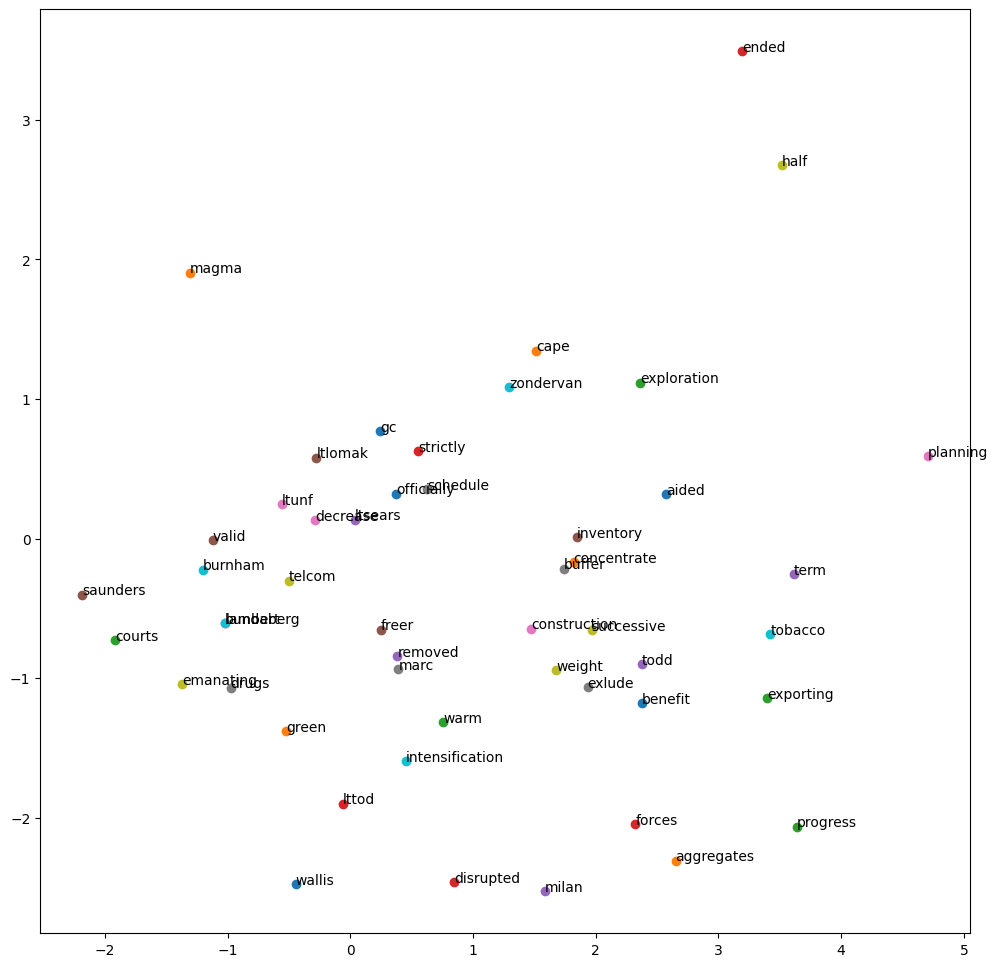

In [53]:
import matplotlib.pyplot as plt
import sklearn

def visualize_word_vectors(words, input_weights):
    word_vectors = get_word_vectors(words, input_weights)

    fig, ax = plt.subplots(figsize=(12,12))
    for i, (x, y) in enumerate(word_vectors):
        ax.scatter(x, y)
        ax.annotate(words[i], (x, y))
    
    plt.show()

def get_word_vectors(words, input_weights):
    word_index = {word: i for i, word in enumerate(vocab)}
    return np.array([input_weights[word_index[word]] for word in words])

visualize_word_vectors(random.sample(list(vocab), 50), X_svd)

# Modified Word2Vec Implementation

In [71]:
# Initialize word embeddings and weights
W1 = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
W2 = np.random.uniform(-1, 1, (embedding_dim, vocab_size))

In [72]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u

In [73]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

In [74]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    # print("dl_weight_inp_hidden --- ", dl_weight_inp_hidden)
    # print(dl_weight_inp_hidden.sum())
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    # print("dl_weight_hidden_output --- ",dl_weight_hidden_output)
    
    # Update weights
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

In [75]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

In [76]:
def generate_training_data2(tokens, window_size, vocab_size, word_index):

    training_data = []
    training_sample_words = []
    for i, word in enumerate(tokens):
        target_word = word
        context_words = []

        if target_word in vocab:
            ncw = set()
            context_words = tokens[max(0, i - window_size):i] + tokens[i + 1:min(len(tokens), i + window_size + 1)]
            trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_index)
            training_data.append([trgt_word_vector,ctxt_word_vector])
            training_sample_words.append([target_word,context_words])  
            
    return training_data, training_sample_words

In [77]:
training_data,training_sample_words = generate_training_data2(tokens,window_size,vocab_size,word_index)
for i in range(len(training_data[:5])):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))

**************************************************
Target word:asian . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['exporters', 'fear', 'damage', 'usjapan', 'rift'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target word:exporters . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['asian', 'fear', 'damage', 'usjapan', 'rift', 'mounting'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target word:fear . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['asian', 'exporters', 'damage', 'usjapan', 'rift', 'mounting', 'trade'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target word:damage . Target vector: [0. 0. 0. ... 0. 0. 0.] 
Context word:['asian', 'exporters', 'fear', 'usjapan', 'rift', 'mounting', 'trade', 'friction'] . Context  vector: [0. 0. 0. ... 0. 0. 0.] 
**************************************************
Target 

In [78]:
#For analysis purposes
epoch_loss = []
weights_1 = []
weights_2 = []

# Reducing epoch size and training data size because taking too much time to train
epochs = 5 

for epoch in range(epochs):
    loss = 0

    for target,context in training_data[:5000]:
        y_pred, hidden_layer, u = forward_prop(W1,W2,target)

        total_error = calculate_error(y_pred, context)

        W1,W2 = backward_prop(
            W1,W2 ,total_error, hidden_layer, target,learning_rate
        )

        loss_temp = calculate_loss(u,context)
        loss += loss_temp
    
    epoch_loss.append( loss )
    weights_1.append(W1)
    weights_2.append(W2)
    
    print('Epoch: %s. Loss:%s' %(epoch,loss))

Epoch: 0. Loss:452671.0619431524
Epoch: 1. Loss:300082.4088567278
Epoch: 2. Loss:256905.1416694213
Epoch: 3. Loss:248145.59382186973
Epoch: 4. Loss:242964.94872225335


In [81]:
ans = wordreturn('dollar', 'currency', 'yen', W1)
print(list(ans.keys())[:10])

['currency', 'yen', 'view', 'merged', 'attributing', 'following', 'regain', 'indonesia', 'trillion', 'sifi']


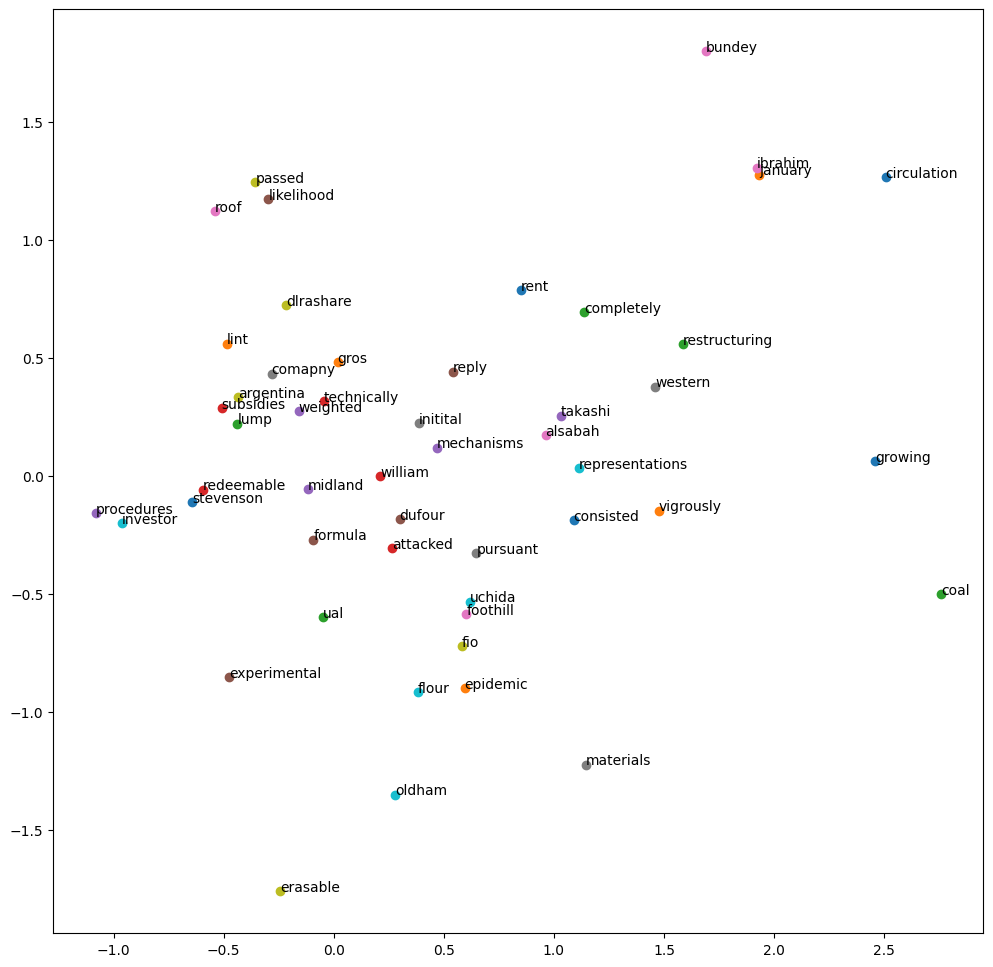

In [80]:
svd2 = TruncatedSVD(n_components=2)
X_svd2 = svd.fit_transform(W1)

def visualize_word_vectors(words, input_weights):
    word_vectors = get_word_vectors(words, input_weights)

    fig, ax = plt.subplots(figsize=(12,12))
    for i, (x, y) in enumerate(word_vectors):
        ax.scatter(x, y)
        ax.annotate(words[i], (x, y))
    
    plt.show()

def get_word_vectors(words, input_weights):
    word_index = {word: i for i, word in enumerate(vocab)}
    return np.array([input_weights[word_index[word]] for word in words])

visualize_word_vectors(random.sample(list(vocab), 50), X_svd2)